# Neuromorphic Spiking Neural Network Classifier

This notebook explores neuromorphic computing using spiking neural networks (SNNs). We define a deep learning model that processes information using biologically inspired neurons. The network learns to classify images from the MNIST dataset by encoding them into spike trains using different encoding methods (rate, time, and delta coding).

The notebook aims to compare effectivness of different encoding schemas for spking neural networks.

This serves as a hands-on implementation of spiking neural networks for image classification, leveraging PyTorch and snnTorch. 🚀🔬

## Imports

In [2]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 8.2 MB/s eta 0:00:00


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate
from snntorch.functional.acc import accuracy_rate
from snntorch.functional.acc import accuracy_temporal
from snntorch.functional.loss import SpikeTime
from snntorch.functional.loss import ce_count_loss
from snntorch.functional.loss import ce_temporal_loss
import snntorch.spikeplot as splt
from IPython.display import HTML

## Variables

In [4]:
BATCH_SIZE = 64
IMAGE_REPITIONS = 4
EPOCHS = 30
SPIKE_GRAD = surrogate.fast_sigmoid(slope=25) #
BETA = 0.5
NUM_STEPS = 10
GAIN = 0.5
THRESHOLD_LATENCY = 1e-4
TAU = 0.9
THRESHOLD_DELTA = 0.5
NUM_CLASSES = 10

## Data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)


print(f"Number of training images: {len(trainset)}")
print(f"Number of test images: {len(testset)}")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 149MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 49.7MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 66.0MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.27MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Number of training images: 60000
Number of test images: 10000


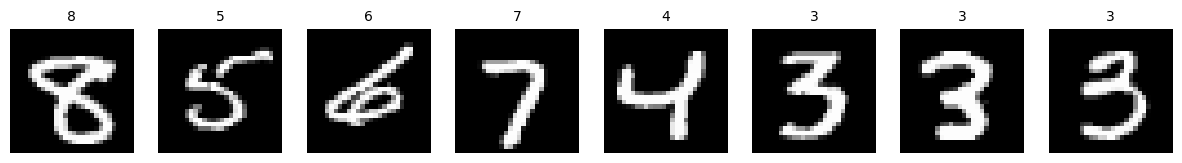

In [6]:
def plot_example(imgs, class_labels, num_images=10):
    '''
    Plots a sample of images along with their corresponding class labels.

    Parameters:
    imgs (torch.Tensor): A tensor of images with shape (N, C, H, W).
    class_labels (torch.Tensor): A tensor containing class labels corresponding to each image.
    num_images (int, optional): The number of images to display. Defaults to 10.

    Returns:
    None
    '''
    imgs = imgs[:num_images]
    class_labels = class_labels[:num_images]
    imgs = imgs.numpy().transpose((0, 2, 3, 1))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].axis("off")
        axes[i].set_title(class_labels[i].item(), fontsize=10)

    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
plot_example(images, labels, num_images=8)

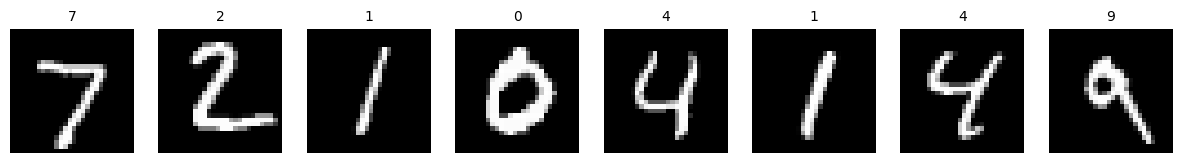

In [7]:
dataiter = iter(testloader)
images, labels = next(dataiter)
plot_example(images, labels, num_images=8)

## Rate encoding

Description via: https://snntorch.readthedocs.io/en/latest/index.html

One example of converting input data into a rate code is as follows.
Each normalised input feature $X_{ij}$ is used as the probability an event (spike) occurs at any given time step, returning a rate-coded value $R_{ij}$. This can be treated as a Bernoulli trial: $R_{ij}\sim B(n,p)$, where the number of trials is $n=1$, and the probability of success (spiking) is $p=X_{ij}$. Explicitly, the probability a spike occurs is:

$${\rm P}(R_{ij}=1) = X_{ij} = 1 - {\rm P}(R_{ij} = 0)$$

For an MNIST image, this probability of spiking corresponds to the pixel value. A white pixel corresponds to a 100% probability of spiking, and a black pixel will never generate a spike.

In [8]:
spike_data = spikegen.rate(images, num_steps=NUM_STEPS, gain=GAIN)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
vid = HTML(anim.to_html5_video())
plt.close(fig)
vid

## Latency Encoding

Description via: https://snntorch.readthedocs.io/en/latest/index.html

Temporal codes capture information about the precise firing time of neurons; a single spike carries much more meaning than in rate codes which rely on firing frequency. While this opens up more susceptibility to noise, it can also decrease the power consumed by the hardware running SNN algorithms by orders of magnitude.

`spikegen.latency` is a function that allows each input to fire at most **once** during the full time sweep.
Features closer to `1` will fire earlier and features closer to `0` will fire later. I.e., in our MNIST case, bright pixels will fire earlier and dark pixels will fire later.

In [9]:
spike_data = spikegen.latency(images, num_steps=NUM_STEPS, tau=TAU, threshold=THRESHOLD_LATENCY)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
vid = HTML(anim.to_html5_video())
plt.close(fig)
vid

## Delta Encoding

Description via: https://snntorch.readthedocs.io/en/latest/index.html

Delta modulation is based on event-driven spiking. The `snntorch.delta` function accepts a time-series tensor as input. It takes the difference between each subsequent feature across all time steps. By default, if the difference is both *positive* and *greater than the threshold $V_{thr}$*, a spike is generated.

In our case, to make the example suitable for the delta encoding we can use the raet encoding and then the delta encoding on the output to generate the time-series encoding.

In [10]:
spike_data = spikegen.delta(spikegen.rate(images, num_steps=NUM_STEPS, gain=GAIN), threshold=THRESHOLD_DELTA, off_spike=True)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
vid = HTML(anim.to_html5_video())
plt.close(fig)
vid

## Model

In [11]:
class Neuromorphic_Net(nn.Module):
    '''
    A spiking neural network (SNN) model using leaky integrate-and-fire (LIF) neurons.

    Parameters:
    input_shape (tuple): Shape of the input data (batch_size, channels, height, width).
    num_classes (int): Number of output classes for classification.

    Attributes:
    conv1 (nn.Conv2d): First convolutional layer.
    lif1 (snn.Leaky): First LIF layer.
    conv2 (nn.Conv2d): Second convolutional layer.
    lif2 (snn.Leaky): Second LIF layer.
    conv3 (nn.Conv2d): Third convolutional layer.
    lif3 (snn.Leaky): Third LIF layer.
    output (nn.Linear): Fully connected output layer.
    lif4 (snn.Leaky): Fourth LIF layer.

    Methods:
    get_covnolution_output(): Computes the flattened output size after convolutional layers.
    reset_states(): Resets the membrane potentials of LIF layers.
    forward(x): Performs a forward pass through the network.

    Returns:
    torch.Tensor: Output spike activity of the final layer.
    '''
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.in_channels = input_shape[1]
        self.conv1 = nn.Conv2d(self.in_channels, 4, 3)
        self.lif1 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.lif2 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD)
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.lif3 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD)
        self.output = nn.Linear(self.get_covnolution_output(), self.num_classes)
        self.lif4 = snn.Leaky(beta=BETA, spike_grad=SPIKE_GRAD)

    def get_covnolution_output(self):
        dummy_input = torch.rand(*self.input_shape)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        cur1 = F.max_pool2d(self.conv1(dummy_input), 2)
        spk1, mem1 = self.lif1(cur1, mem1)
        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)
        cur3 = F.max_pool2d(self.conv3(spk2), 2)
        spk3, mem3 = self.lif3(cur3, mem3)
        return spk3.view(BATCH_SIZE, -1).shape[-1]

    def reset_states(self):
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()
        self.mem3 = self.lif3.init_leaky()
        self.mem4 = self.lif4.init_leaky()

    def forward(self, x):
        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, self.mem1 = self.lif1(cur1, self.mem1)
        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, self.mem2 = self.lif2(cur2, self.mem2)
        cur3 = F.max_pool2d(self.conv3(spk2), 2)
        spk3, self.mem3 = self.lif3(cur3, self.mem3)
        output = self.output(spk3.view(spk3.shape[0], -1))
        spk4, self.mem4 = self.lif4(output, self.mem4)
        return spk4

model = Neuromorphic_Net(images.shape, NUM_CLASSES)
model.reset_states()
print(model)
print(model(torch.rand(64, *images[0].shape)).shape)
print(model(torch.rand(16, *images[0].shape)).shape)

num_parameters = 0
for parameter in model.parameters():
    num_parameters+=parameter.detach().numpy().size

print(f"Number of Parameters: {num_parameters}")

Neuromorphic_Net(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (lif1): Leaky()
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (lif2): Leaky()
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (lif3): Leaky()
  (output): Linear(in_features=16, out_features=10, bias=True)
  (lif4): Leaky()
)
torch.Size([64, 10])
torch.Size([16, 10])
Number of Parameters: 1674


In [12]:
def encode_rate(input):
    '''
    Encodes input data into spike trains using rate coding.

    Parameters:
    input (torch.Tensor): Input tensor to be encoded.

    Returns:
    torch.Tensor: Rate-encoded spike train.
    '''
    return spikegen.rate(input, num_steps=NUM_STEPS, gain=GAIN)

def encode_time(input):
    '''
    Encodes input data into spike trains using time-to-first-spike (latency) coding.

    Parameters:
    input (torch.Tensor): Input tensor to be encoded.

    Returns:
    torch.Tensor: Time-encoded spike train.
    '''
    return spikegen.latency(input, num_steps=NUM_STEPS, tau=TAU, threshold=THRESHOLD_LATENCY)

def encode_delta(input):
    '''
    Encodes input data using delta modulation, based on changes in rate-coded spikes.

    Parameters:
    input (torch.Tensor): Input tensor to be encoded.

    Returns:
    torch.Tensor: Delta-encoded spike train.
    '''
    return spikegen.delta(spikegen.rate(input, num_steps=NUM_STEPS, gain=GAIN), threshold=THRESHOLD_DELTA, off_spike=True)

def train(model, optimizer, criterion, dataset, encoding, accuracy_fn):
    '''
    Trains the Neuromorphic_Net model.

    Parameters:
    model (Neuromorphic_Net): The neural network model to be trained.
    optimizer (torch.optim.Optimizer): Optimizer for training the model.
    criterion (torch.nn.Module): Loss function used for training.
    dataset (torch.utils.data.DataLoader): Training dataset loader.
    encoding (function): Function for encoding input data into spike trains.
    accuracy_fn (function): Function to compute model accuracy.

    Returns:
    Neuromorphic_Net: The trained model.
    '''
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0.0
        total_accuracy = 0.0
        for imgs, labels in dataset:
            inputs_temporal = encoding(imgs)
            optimizer.zero_grad()
            outputs = []
            model.reset_states()
            for inputs in inputs_temporal:
                outputs_step = model(inputs)
                outputs.append(outputs_step)
            outputs = torch.stack(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_accuracy += accuracy_fn(outputs, labels)
        print(f"Epoch {epoch}: Loss: {total_loss/len(dataset):.4f} Accuracy: {total_accuracy/len(dataset):.4f}")
    return model

def test(model, criterion, dataset, encoding, accuracy_fn):
    '''
    Evaluates the Neuromorphic_Net model on a test dataset.

    Parameters:
    model (Neuromorphic_Net): The trained neural network model.
    criterion (torch.nn.Module): Loss function used for evaluation.
    dataset (torch.utils.data.DataLoader): Test dataset loader.
    encoding (function): Function for encoding input data into spike trains.
    accuracy_fn (function): Function to compute model accuracy.

    Returns:
    None
    '''
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    for imgs, labels in dataset:
        inputs_temporal = encoding(imgs)
        outputs = []
        model.reset_states()
        for inputs in inputs_temporal:
            with torch.no_grad():
                outputs_step = model(inputs)
            outputs.append(outputs_step)
        outputs = torch.stack(outputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        total_accuracy += accuracy_fn(outputs, labels)
    print(f"Test Loss: {total_loss/len(dataset):.4f} Test Accuracy: {total_accuracy/len(dataset):.4f}")

### Model - Rate

In [12]:
model = Neuromorphic_Net(images.shape, NUM_CLASSES)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = ce_count_loss(population_code=True, num_classes=NUM_CLASSES)
model = train(model, optimizer, loss_fn, trainloader, encode_rate, accuracy_rate)
test(model, loss_fn, testloader, encode_rate, accuracy_rate)

torch.save(model.state_dict(), "neuromorphic_rate_model.pth")
print("Model saved as neuromorphic_rate_model.pth")

Epoch 0: Loss: 1.4634 Accuracy: 0.4687
Epoch 1: Loss: 0.7309 Accuracy: 0.7540
Epoch 2: Loss: 0.5543 Accuracy: 0.8204
Epoch 3: Loss: 0.4690 Accuracy: 0.8496
Epoch 4: Loss: 0.4212 Accuracy: 0.8657
Epoch 5: Loss: 0.3914 Accuracy: 0.8768
Epoch 6: Loss: 0.3601 Accuracy: 0.8851
Epoch 7: Loss: 0.3452 Accuracy: 0.8911
Epoch 8: Loss: 0.3274 Accuracy: 0.8965
Epoch 9: Loss: 0.3159 Accuracy: 0.9008
Epoch 10: Loss: 0.3019 Accuracy: 0.9044
Epoch 11: Loss: 0.2905 Accuracy: 0.9082
Epoch 12: Loss: 0.2838 Accuracy: 0.9114
Epoch 13: Loss: 0.2739 Accuracy: 0.9143
Epoch 14: Loss: 0.2659 Accuracy: 0.9170
Epoch 15: Loss: 0.2575 Accuracy: 0.9197
Epoch 16: Loss: 0.2550 Accuracy: 0.9201
Epoch 17: Loss: 0.2501 Accuracy: 0.9221
Epoch 18: Loss: 0.2466 Accuracy: 0.9224
Epoch 19: Loss: 0.2417 Accuracy: 0.9248
Epoch 20: Loss: 0.2383 Accuracy: 0.9268
Epoch 21: Loss: 0.2343 Accuracy: 0.9277
Epoch 22: Loss: 0.2292 Accuracy: 0.9291
Epoch 23: Loss: 0.2265 Accuracy: 0.9290
Epoch 24: Loss: 0.2238 Accuracy: 0.9296
Epoch 25: 

### Model - Delta

In [13]:
model = Neuromorphic_Net(images.shape, NUM_CLASSES)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = ce_count_loss(population_code=True, num_classes=NUM_CLASSES)
model = train(model, optimizer, loss_fn, trainloader, encode_delta, accuracy_rate)
test(model, loss_fn, testloader, encode_delta, accuracy_rate)

torch.save(model.state_dict(), "neuromorphic_delta_model.pth")
print("Model saved as neuromorphic_delta_model.pth")

Epoch 0: Loss: 1.4367 Accuracy: 0.4773
Epoch 1: Loss: 0.8208 Accuracy: 0.7162
Epoch 2: Loss: 0.6608 Accuracy: 0.7821
Epoch 3: Loss: 0.5463 Accuracy: 0.8266
Epoch 4: Loss: 0.4707 Accuracy: 0.8510
Epoch 5: Loss: 0.4354 Accuracy: 0.8608
Epoch 6: Loss: 0.4009 Accuracy: 0.8734
Epoch 7: Loss: 0.3817 Accuracy: 0.8786
Epoch 8: Loss: 0.3648 Accuracy: 0.8827
Epoch 9: Loss: 0.3482 Accuracy: 0.8885
Epoch 10: Loss: 0.3263 Accuracy: 0.8966
Epoch 11: Loss: 0.3126 Accuracy: 0.9007
Epoch 12: Loss: 0.2980 Accuracy: 0.9056
Epoch 13: Loss: 0.2917 Accuracy: 0.9078
Epoch 14: Loss: 0.2813 Accuracy: 0.9115
Epoch 15: Loss: 0.2700 Accuracy: 0.9142
Epoch 16: Loss: 0.2618 Accuracy: 0.9184
Epoch 17: Loss: 0.2572 Accuracy: 0.9190
Epoch 18: Loss: 0.2508 Accuracy: 0.9206
Epoch 19: Loss: 0.2499 Accuracy: 0.9206
Epoch 20: Loss: 0.2450 Accuracy: 0.9224
Epoch 21: Loss: 0.2390 Accuracy: 0.9246
Epoch 22: Loss: 0.2356 Accuracy: 0.9257
Epoch 23: Loss: 0.2349 Accuracy: 0.9268
Epoch 24: Loss: 0.2319 Accuracy: 0.9268
Epoch 25: 

### Model - Latency

In [13]:
model = Neuromorphic_Net(images.shape, NUM_CLASSES)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = ce_temporal_loss()
model = train(model, optimizer, loss_fn, trainloader, encode_time, accuracy_temporal)
test(model, loss_fn, testloader, encode_time, accuracy_temporal)

torch.save(model.state_dict(), "neuromorphic_temporal_model.pth")
print("Model saved as neuromorphic_temporal_model.pth")

Epoch 0: Loss: 2.3026 Accuracy: 0.0987
Epoch 1: Loss: 2.3017 Accuracy: 0.1001
Epoch 2: Loss: 2.0758 Accuracy: 0.2160
Epoch 3: Loss: 1.9200 Accuracy: 0.2722
Epoch 4: Loss: 1.8906 Accuracy: 0.2815
Epoch 5: Loss: 1.9493 Accuracy: 0.2551
Epoch 6: Loss: 2.1283 Accuracy: 0.1942
Epoch 7: Loss: 2.0177 Accuracy: 0.2515
Epoch 8: Loss: 2.1449 Accuracy: 0.2168
Epoch 9: Loss: 2.2548 Accuracy: 0.1611
Epoch 10: Loss: 1.9626 Accuracy: 0.3303
Epoch 11: Loss: 1.7979 Accuracy: 0.3712
Epoch 12: Loss: 1.7614 Accuracy: 0.4002
Epoch 13: Loss: 1.5629 Accuracy: 0.5012
Epoch 14: Loss: 1.4515 Accuracy: 0.5244
Epoch 15: Loss: 1.5337 Accuracy: 0.4942
Epoch 16: Loss: 1.4935 Accuracy: 0.5332
Epoch 17: Loss: 1.4383 Accuracy: 0.5591
Epoch 18: Loss: 1.3750 Accuracy: 0.5846
Epoch 19: Loss: 1.3320 Accuracy: 0.6047
Epoch 20: Loss: 1.4077 Accuracy: 0.6026
Epoch 21: Loss: 1.3161 Accuracy: 0.6212
Epoch 22: Loss: 1.3548 Accuracy: 0.6088
Epoch 23: Loss: 1.3194 Accuracy: 0.5974
Epoch 24: Loss: 1.3007 Accuracy: 0.6106
Epoch 25: 

For further study I recommend the [SNNTorch documentation](https://snntorch.readthedocs.io/en/latest/index.html)